In [29]:
import tensorflow as tf
import erum_data_data as edd #import the erum_data_data module
import numpy as np
import matplotlib.pyplot as plt

In [45]:
ds = 'airshower'
edd.print_description(ds)


    
Airshower Proton vs Iron Classification

Based on https://doi.org/10.1016/j.astropartphys.2017.10.006

Produced by jonas.glombitza@rwth-aachen.de
    
----------------------------------    
Dataset shape:

Three sets of input data:
- first set of input data:
    - 70k events (airshowers)
    - 81 ground detector stations
    - 81 features
        - 1  time   (arrival time of first particles at each station)
        - 80 measured signal traces
    -padding: (-1) padding for instances that the detector / or timestep did not detect a particle
    
- second set of input data:
    - 70k events (airshowers)
    - 11 features per airshower:
        'logE',  --> (energy of cosmic ray)
        'Xmax',  --> (depth of shower maximum)  
        'showermax_x', 'showermax_y', 'showermax_z',     --> (point of showermaximum in x,y,z)
        'showeraxis_x', 'showeraxis_y', 'showeraxis_z',  --> (shower axis (arrival direction) in x,y,z)
        'showercore_x', 'showercore_y', 'showercore_z',  -->

In [46]:
# loading training data into RAM (downloads dataset first time)

X_train, y_train  = edd.load(ds, dataset='train', cache_dir = './'+ ds, cache_subdir = 'datasets')
X_test, y_test = edd.load(ds, dataset='test', cache_dir = './'+ ds, cache_subdir = 'datasets')

Model: "edd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 81, 81)]     0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 6561)         0           input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 11)]         0                                            
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 256)          1679872     flatten_6[0][0]                  
__________________________________________________________________________________________

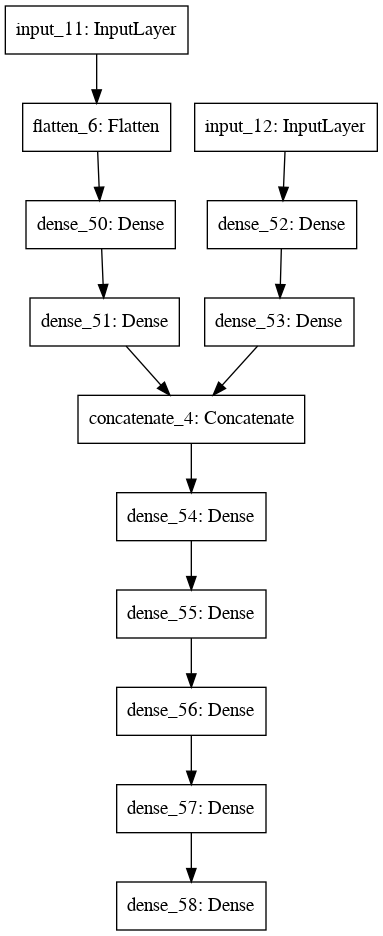

In [47]:
dim1 = X_train[0].shape[1]
dim2 = X_train[0].shape[2]
input2d = tf.keras.Input(shape = (dim1, dim2))
flatten = tf.keras.layers.Flatten()(input2d)
dense_1 = tf.keras.layers.Dense(256, activation = 'relu')(flatten)
dense_2 = tf.keras.layers.Dense(256, activation = 'relu')(dense_1)

if ds == 'airshower' or ds == 'belle':
    dim3 = X_train[1].shape[1]
    input1d = tf.keras.Input(shape = (dim3,))
    dense_3 = tf.keras.layers.Dense(256, activation = 'relu')(input1d)
    dense_4 = tf.keras.layers.Dense(256, activation = 'relu')(dense_3)
    merged  = tf.keras.layers.Concatenate(axis=1)([dense_2, dense_4])
    dense_5 = tf.keras.layers.Dense(256, activation = 'relu')(merged)
    inputs = [input2d, input1d]
else:
    inputs = [input2d]
    dense_5 = tf.keras.layers.Dense(256, activation = 'relu')(dense_2)

dense_6 = tf.keras.layers.Dense(256, activation = 'relu')(dense_5)
dense_7 = tf.keras.layers.Dense(256, activation = 'relu')(dense_6)
dense_8 = tf.keras.layers.Dense(256, activation = 'relu')(dense_7)
output  = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_8)
model = tf.keras.models.Model(inputs = inputs, outputs = output, name = "edd_model")

print(model.summary())
tf.keras.utils.plot_model(model)


In [48]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name = "acc"), tf.keras.metrics.AUC(name = "AUC")],
)

history = model.fit(
                    x = X_train, y = y_train,
                    shuffle=True,
                    validation_split = 0.7,
                    epochs=100,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta =0.01, patience=5)],
                    batch_size = 300,
                )

Train on 21000 samples, validate on 49000 samples
Epoch 1/100
21000/21000 [==============================] - 8s 377us/sample - loss: 123.3390 - acc: 0.5911 - AUC: 0.6009 - val_loss: 6.9295 - val_acc: 0.5714 - val_AUC: 0.6779
Epoch 2/100
21000/21000 [==============================] - 6s 272us/sample - loss: 2.7260 - acc: 0.7443 - AUC: 0.8056 - val_loss: 2.6026 - val_acc: 0.7937 - val_AUC: 0.8374
Epoch 3/100
21000/21000 [==============================] - 6s 275us/sample - loss: 1.0747 - acc: 0.8730 - AUC: 0.9272 - val_loss: 0.3080 - val_acc: 0.9395 - val_AUC: 0.9756
Epoch 4/100
21000/21000 [==============================] - 5s 254us/sample - loss: 0.4303 - acc: 0.9389 - AUC: 0.9735 - val_loss: 0.5436 - val_acc: 0.9202 - val_AUC: 0.9633
Epoch 5/100
21000/21000 [==============================] - 6s 267us/sample - loss: 0.5014 - acc: 0.9379 - AUC: 0.9708 - val_loss: 0.5522 - val_acc: 0.9563 - val_AUC: 0.9756
Epoch 6/100
21000/21000 [==============================] - 6s 270us/sample - loss: 

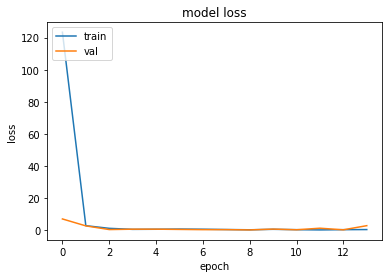

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

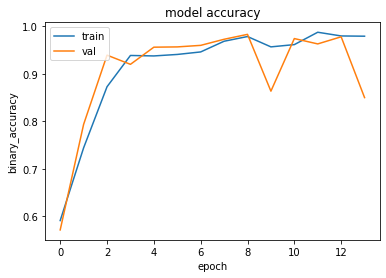

In [50]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

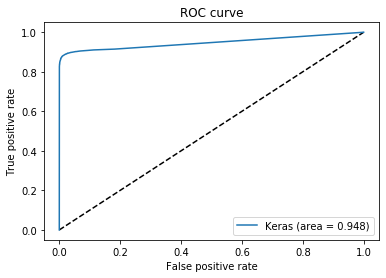

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred = model.predict(X_test).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()